In [9]:
import os
import numpy as np
from PIL import Image
import shap

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

In [10]:
def load_images_recursive(root_dir, label, image_size=(128, 128)):
    """
    Recursively loads images from a directory tree, converts them to grayscale,
    resizes, and flattens them into a NumPy array.

    Parameters:
        root_dir (str): The root directory containing subdirectories with images.
        label (int): The label to assign to each image (e.g., 1 for animal).
        image_size (tuple): Desired image size as (width, height).

    Returns:
        tuple: (X, y, file_paths) where:
               - X is a NumPy array of shape (N, width*height) containing the flattened images,
               - y is an array of labels,
               - file_paths is a dictionary mapping each image index to its file path.
    """
    data = []
    labels = []
    file_paths = {}  # Use a dictionary to map index to file path
    counter = 1     # Start the counter at 1 (or 0 if preferred)

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for fname in filenames:
            fpath = os.path.join(dirpath, fname)
            try:
                # Open the image, convert to grayscale, resize, and flatten it
                img = Image.open(fpath).convert("L").resize(image_size)
                data.append(np.array(img).flatten())
                labels.append(label)
                
                # Store the file path in the dictionary with the current counter as the key
                file_paths[counter] = fpath
                counter += 1
            except Exception as e:
                print(f"Skipping file {fpath} due to error: {e}")
                continue

    return np.array(data), np.array(labels), file_paths

# One-Class SVM for Animal Detection (When Only Animal Images are Available)

This notebook demonstrates how to detect if an image contains an animal, **without** having any non-animal training images. We use a **One-Class SVM**, which learns what “normal” (in this case, *animal*) looks like, and flags anything else as an outlier.

## Key Points
1. **No non-animal data**: We cannot do a standard supervised (binary) classification. We only have *animal* images.
2. **One-Class SVM**: This approach allows us to treat animal images as our "normal" class. At prediction time, if a new image deviates significantly from what the model learned, it's flagged as "Non-Animal."
3. **Hyperparameter Tuning**: We do a simple grid search over parameters like `nu` and `gamma` to find a good fit for our animal data.
4. **Same Function Names**: The required functions are `load_images`, `train_animal_classifier`, and `predict_image`.


## Setup & Imports
We will use:
- `PIL` (via `Pillow`) to handle image loading and resizing.
- `numpy` for numerical arrays.
- `sklearn.svm.OneClassSVM` for our one-class model.
- `train_test_split` to create a validation set from our animal images.


In [11]:
def train_animal_classifier(animal_path, image_size=(128, 128)):
    """
    Trains a One-Class SVM using only animal images. This function expects that
    animal_path is a root folder that contains subfolders of images. No non-animal
    data is used.

    The process includes:
      1. Recursively loading animal images.
      2. Splitting the data into training (80%) and validation (20%) sets.
      3. A manual grid search over a small set of hyperparameters for OneClassSVM.
      4. Returning the best model (based on minimal outlier rate on the validation set)
         along with the training data for later use as background data in explainability.

    Parameters:
        animal_path (str): Path to the root folder of animal images (folder-of-folders).
        image_size (tuple): Desired image size as (width, height).

    Returns:
        tuple: (best_model, X_train)
    """
    # Load images recursively from the animal training folder.
    X, _, image_file_paths = load_images_recursive(animal_path, label=1, image_size=image_size)
    if len(X) == 0:
        raise ValueError(f"No images found in '{animal_path}'. Cannot train the model.")
    print(f"Loaded {len(X)} animal images.")

    # Split the data into training and validation sets.
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
    print(f"Training set size: {len(X_train)} images")

    # Define a grid of hyperparameters for OneClassSVM.
    param_grid = {
        "nu":    [0.001, 0.01, 0.1],   # Controls fraction of outliers.
        "gamma": [0.005, 1e-3, 1e-4]   # Kernel coefficient for RBF.
    }

    best_model = None
    best_outlier_rate = float("inf")
    best_params = None

    # Perform a manual grid search over hyperparameters.
    for nu_val in param_grid["nu"]:
        for gamma_val in param_grid["gamma"]:
            print(f"Training One-Class SVM with nu={nu_val}, gamma={gamma_val}...")
            model = OneClassSVM(kernel="rbf", nu=nu_val, gamma=gamma_val)
            model.fit(X_train)

            # Predict on the validation set: +1 for inliers, -1 for outliers.
            val_preds = model.predict(X_val)
            outlier_count = np.sum(val_preds == -1)
            outlier_rate = outlier_count / len(X_val)

            if outlier_rate < best_outlier_rate:
                best_outlier_rate = outlier_rate
                best_model = model
                best_params = (nu_val, gamma_val)
            print(f"Outlier rate: {outlier_rate:.2%}")

    print(f"Best One-Class SVM params: nu={best_params[0]}, gamma={best_params[1]}")
    print(f"Validation outlier rate on animal data: {best_outlier_rate:.2%}")

    # Return the best model and training data for later explainability.
    return best_model, X_train, image_file_paths

def predict_image(file_path, model, image_size=(64, 64)):
    """
    Predicts whether an image is 'Animal' or 'Non-Animal' based on the trained OneClassSVM.

    Parameters:
        file_path (str): Path to the image file.
        model (OneClassSVM): Trained OneClassSVM model.
        image_size (tuple): Desired image size as (width, height).

    Returns:
        str: "Animal" if the model predicts +1, otherwise "Non-Animal".
    """
    img = Image.open(file_path).convert("L").resize(image_size)
    arr = np.array(img).flatten().reshape(1, -1)
    prediction = model.predict(arr)[0]
    return "Animal" if prediction == 1 else "Non-Animal"


## Example Usage
Assume you have a folder structure like this:
```
data/
  animals/
    animal1.jpg
    animal2.jpg
    ...
```

## How It Works
1. **Load & Preprocess**: Converts images to grayscale, resizes them to 64×64, and flattens them into 1D arrays.
2. **Train/Validation Split**: Splits the available *animal* images into train (80%) and validation (20%).
3. **One-Class SVM**: The model learns a decision boundary around your *animal* data. Anything that deviates significantly is labeled as "-1" (outlier).
4. **Hyperparameter Tuning**: We do a simple loop over a small grid of `(nu, gamma)` values:
   - `nu` controls the fraction of outliers allowed in the training set.
   - `gamma` is the kernel coefficient for the RBF kernel.
   - We pick the combination that yields the **fewest** outliers on the validation set.
5. **Prediction**: `predict_image` loads a new image and runs the trained One-Class SVM. The result is either +1 ("Animal") or -1 ("Non-Animal").

> **Important**: Because we have no real non-animal data for training or testing, we cannot measure the false positive rate (i.e., how often it labels a non-animal as "Animal").

In [12]:
animal_images_dir = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\as_conservationistFrankfurt\IE_Forest_County_Wicklow_21_loc_01-20241031T145429Z-001" 

In [ ]:
model, X_train, image_file_paths = train_animal_classifier(animal_images_dir, image_size=(64, 64))

In [7]:
# test_image_path = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0197.JPG"
test_image_path = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0001.JPG"
prediction = predict_image(test_image_path, model, image_size=(64, 64))
print(f"Prediction for {test_image_path}: {prediction}")

Prediction for C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0001.JPG: Animal


Reduced training data shape: (3432, 2)


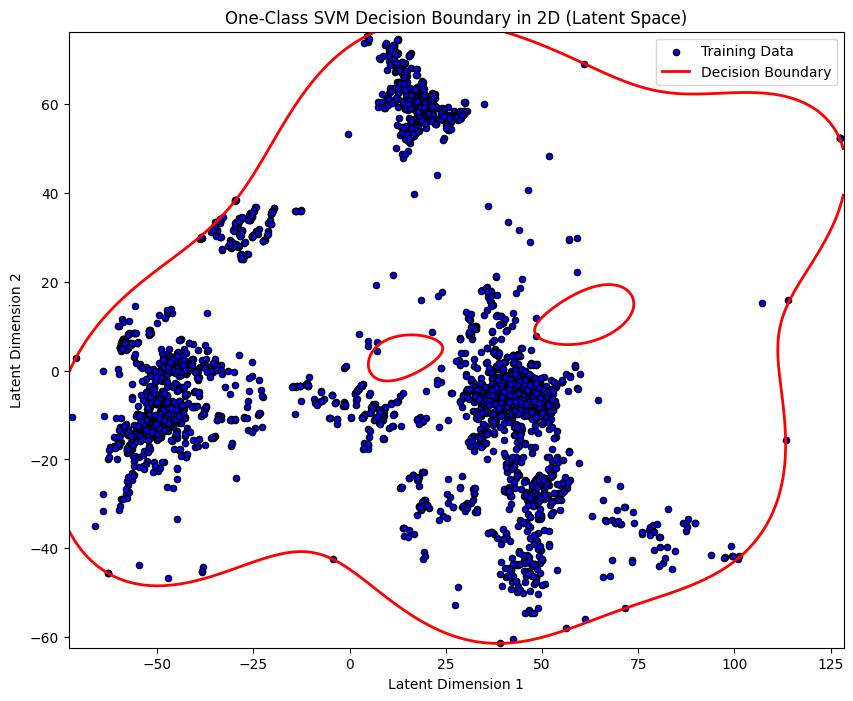

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# --- Step 1: Scale the data before applying PCA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- Step 2: Reduce to 2D latent space using PCA ---
pca = PCA(n_components=2)
X_train_latent = pca.fit_transform(X_train_scaled)
print(f"Reduced training data shape: {X_train_latent.shape}")

# --- Step 3: Train the One-Class SVM on the latent data ---
# Experiment with nu and gamma to adjust the smoothness of the boundary.
svm_latent = OneClassSVM(kernel='rbf', nu=0.001, gamma=0.005)
svm_latent.fit(X_train_latent)

# --- Step 4: Create a grid over the latent space for contour plotting ---
xx, yy = np.meshgrid(
    np.linspace(X_train_latent[:, 0].min() - 1, X_train_latent[:, 0].max() + 1, 1000),
    np.linspace(X_train_latent[:, 1].min() - 1, X_train_latent[:, 1].max() + 1, 1000)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the decision function on the grid.
Z = svm_latent.decision_function(grid)
Z = Z.reshape(xx.shape)

# --- Step 5: Plot the latent data and decision boundary ---
plt.figure(figsize=(10, 8))
plt.scatter(X_train_latent[:, 0], X_train_latent[:, 1],
            c='blue', s=20, edgecolor='k', label='Training Data')

# Plot the decision boundary where the decision function equals zero.
contour = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.plot([], [], color='red', linewidth=2, label='Decision Boundary')

plt.title("One-Class SVM Decision Boundary in 2D (Latent Space)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()